In [1]:
#| default_exp learner

In [2]:
#| export
import math, torch, matplotlib.pyplot as plt

import fastcore.all as fc
from collections.abc import Mapping
from operator import attrgetter
from functools import partial
from copy import copy

from torch import optim
import torch.nn.functional as F

from fastai_course.conv import *

from fastprogress import progress_bar,master_bar

('a', 'd', 'g')


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import matplotlib as mpl
import torchvision.transforms.functional as TF
from contextlib import contextmanager
from torch import nn,tensor
from datasets import load_dataset,load_dataset_builder
from fastai_course.datasets import *
import logging
from fastcore.test import test_close

In [5]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

In [6]:
logging.disable(logging.ERROR)

In [7]:
x,y = 'image','label'
name = 'fashion_mnist'
dsd = load_dataset(name)

In [8]:
dsd['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

In [9]:
@inplace
def transformi(b):
    b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [10]:
bs = 1024
tds = dsd.with_transform(transformi)

In [11]:
tds['train'][0]['image'].shape

torch.Size([784])

In [12]:
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb, yb = next(iter(dt))
xb.shape, yb.shape, yb[:10]

(torch.Size([1024, 784]),
 torch.Size([1024]),
 tensor([5, 4, 9, 4, 3, 0, 6, 5, 7, 6]))

In [13]:
#|export
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

In [14]:
#|export
class Callback(): order = 0

In [15]:
a = Callback()

In [16]:
attrgetter('order')(a)

0

In [107]:
#|export
def run_cbs(cbs, method_nm, learn=None):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None)
        # print(method)
        if method is not None: method(learn)

In [108]:
class CompletionCB(Callback):
    def before_fit(self, learn): self.count = 0
    def after_batch(self, learn): self.count += 1
    def after_fit(self, learn): print(f'completed {self.count} batches')

In [109]:
cbs = [CompletionCB()]
run_cbs(cbs, 'before_fit')
run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'after_fit')

completed 1 batches


In [110]:
class Learner():
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD): fc.store_attr()

    def one_batch(self):
        self.preds = self.model(self.batch[0])
        self.loss = self.loss_func(self.preds, self.batch[1])
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
    
    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        try:
            self.callback('before_epoch')
            for self.iter, self.batch in enumerate(self.dl):
                try:
                    self.callback('before_batch')
                    self.one_batch()
                    self.callback('after_batch')
                except CancelBatchException: pass
            self.callback('after_epoch')
        except CancelEpochException: pass
    
    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        try:
            self.callback('before_fit')
            for self.epoch in self.epochs:
                self.one_epoch(True)
                self.one_epoch(False)
            self.callback('after_fit')
        except CancelFitException: pass
    
    def callback(self, method_name):
        run_cbs(self.cbs, method_name, self)

In [111]:
m, nh = 28*28, 50
model = nn.Sequential(
    nn.Linear(m, nh),
    nn.ReLU(),
    nn.Linear(nh, 10)
)

In [112]:
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[CompletionCB()])
learn.fit(1)

completed 64 batches


In [113]:
#| export
class SingleBatchCB(Callback):
    order = 1
    def after_batch(self, learn): 
        print('stop training')
        raise CancelFitException()

In [114]:
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[CompletionCB(), SingleBatchCB()])
learn.fit(1)

stop training


In [115]:
#| export
from torcheval.metrics import MulticlassAccuracy, Mean, BinaryNormalizedEntropy

In [116]:
metric = MulticlassAccuracy()
metric.update(tensor([0, 2, 1, 3]), tensor([0, 1, 2, 3]))
metric.compute()

tensor(0.50)

In [117]:
metric.reset()
metric.compute()

tensor(nan)

In [118]:
#| export
def to_cpu(x):
    if isinstance(x, Mapping):
        return {k: to_cpu(v) for k, v in x.items()}
    if isinstance(x, list):
        return [to_cpu(o) for o in x]
    if isinstance(x, tuple):
        return tuple(to_cpu(list(x)))
    res = x.detach().cpu()
    return res.float() if res.dtype==torch.float16 else res

In [119]:
#| export
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()
        print(self.metrics)
    
    def _log(self, d): print(d)
    def before_fit(self, learn): learn.metrics = self
    def before_epoch(self, learn):
        [o.reset() for o in self.all_metrics.values()]
    
    def after_epoch(self, learn):
        log = {k: f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)
    
    def after_batch(self, learn):
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values():
            m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))

In [120]:
#| export
class DeviceCB(Callback):
    def __init__(self, device=def_device): fc.store_attr()

    def before_fit(self, learn):
        if hasattr(learn.model, 'to'): learn.model.to(self.device)
    
    def before_batch(self, learn):
        learn.batch = to_device(learn.batch, device=self.device)

In [121]:
def get_model():
    return nn.Sequential(
        nn.Linear(m, nh),
        nn.ReLU(),
        nn.Linear(nh, 10)
    )

In [122]:
model = get_model()
metrics = MetricsCB(accuracy=MulticlassAccuracy())

{'accuracy': <torcheval.metrics.classification.accuracy.MulticlassAccuracy object at 0x306b2eaa0>}


In [123]:
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[DeviceCB(), metrics])
learn.fit(5)

{'accuracy': '0.611', 'loss': '1.181', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.708', 'loss': '0.797', 'epoch': 0, 'train': 'eval'}
{'accuracy': '0.746', 'loss': '0.711', 'epoch': 1, 'train': 'train'}
{'accuracy': '0.758', 'loss': '0.680', 'epoch': 1, 'train': 'eval'}
{'accuracy': '0.778', 'loss': '0.621', 'epoch': 2, 'train': 'train'}
{'accuracy': '0.783', 'loss': '0.596', 'epoch': 2, 'train': 'eval'}
{'accuracy': '0.804', 'loss': '0.561', 'epoch': 3, 'train': 'train'}
{'accuracy': '0.794', 'loss': '0.561', 'epoch': 3, 'train': 'eval'}
{'accuracy': '0.808', 'loss': '0.538', 'epoch': 4, 'train': 'train'}
{'accuracy': '0.744', 'loss': '0.635', 'epoch': 4, 'train': 'eval'}


In [125]:
import contextlib

In [126]:
@contextlib.contextmanager
def simple_context_manager():
    print('Enter')
    yield
    print('Exit')

with simple_context_manager():
    print('Inside the with block')

Enter
Inside the with block
Exit


In [127]:
@contextlib.contextmanager
def buggy_context_manager():
    print("Enter")
    raise Exception("Exception before yield")
    yield
    print("Exit")

try:
    with buggy_context_manager():
        print("Inside the with block")
except Exception as e:
    print(f"Caught exception: {e}")

Enter
Caught exception: Exception before yield


In [128]:
b = next(iter(dls.train))

In [129]:
b[0].shape

torch.Size([1024, 784])

In [130]:
#| export
class TrainerCB(Callback):
    def __init__(self, n_inp=1): fc.store_attr()
    def predict(self, learn):
        learn.preds = learn.model(*learn.batch[:self.n_inp])
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()

In [131]:
t = TrainerCB()
t.n_inp

1

In [132]:
fc.L.range(20).map(lambda x: x * 2)

(#20) [0,2,4,6,8,10,12,14,16,18...]

In [133]:
#|export
class ProgressCB(Callback):
    order = MetricsCB.order + 1
    def __init__(self, plot=False): fc.store_attr()
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.train_losses, self.val_losses = [], []
    
    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)
    
    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self, learn):
        learn.dl.comment = f"{learn.loss:.3f}"
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.train_losses.append(learn.loss.item())
            if self.val_losses:
                self.mbar.update_graph([
                    [fc.L.range(self.train_losses), self.train_losses],
                    [fc.L.range(learn.epoch).map(lambda x: (x+1) * len(learn.dls.train)), self.val_losses]
                ])
    
    def after_epoch(self, learn):
        if not learn.training and self.plot and hasattr(learn, 'metrics'):
            self.val_losses.append(learn.metrics.all_metrics['loss'].compute())
            self.mbar.update_graph([
                    [fc.L.range(self.train_losses), self.train_losses],
                    [fc.L.range(learn.epoch+1).map(lambda x: (x+1) * len(learn.dls.train)), self.val_losses]
                ])

In [134]:
#|export
class with_cbs:
    def __init__(self, nm): fc.store_attr()
    def __call__(self, f):
        # print(self.nm)
        def _f(o, *args, **kwargs):
            try:
                o.callback(f"before_{self.nm}")
                f(o, *args, **kwargs)
                o.callback(f"after_{self.nm}")
            except globals()[f'Cancel{self.nm.title()}Exception']: pass
            finally: o.callback(f'cleanup_{self.nm}')
        
        return _f

In [135]:
cbs = with_cbs('fit')
cbs('a')

<function __main__.with_cbs.__call__.<locals>._f(o, *args, **kwargs)>

In [136]:
class TestClass:
    @with_cbs('batch')
    def _one_batch(self):
        print('test callback')
    
    def callback(self, method_name):
        print(method_name)

In [137]:
t = TestClass()
t._one_batch()

before_batch
test callback
after_batch
cleanup_batch


In [144]:
#| export
class Learner:
    def __init__(self, model, dls=(0,), loss_func=F.cross_entropy, cbs=[], lr=0.1, opt_func=optim.SGD):
        self.model = model
        self.dls = dls
        self.loss_func = loss_func
        self.cbs = cbs
        self.lr = lr
        self.opt_func = opt_func
        # fc.store_attr()
    
    @with_cbs('batch')
    def _one_batch(self):
        self.predict()
        self.callback('after_predict')
        self.get_loss()
        self.callback('after_loss')
        if self.training:
            self.backward()
            self.callback('after_backward')
            self.step()
            self.callback('after_step')
            self.zero_grad()
    
    @with_cbs('epoch')
    def _one_epoch(self):
        for self.iter, self.batch in enumerate(self.dl): self._one_batch()
    
    def one_epoch(self, training):
        self.model.train(training)
        self.dl = self.dls.train if training else self.dls.valid
        self._one_epoch()
    
    @with_cbs('fit')
    def _fit(self, train, valid):
        for self.epoch in self.epochs:
            if train: self.one_epoch(True)
            if valid:
                with torch.no_grad(): self.one_epoch(False)
    
    def fit(self, n_epochs=1, train=True, valid=True):
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self._fit(train, valid)
        # finally:
        #     for cb in cbs: self.cbs.remove(cb)
    
    def callback(self, method_name):
        run_cbs(self.cbs, method_name, self)
    
    def __getattr__(self, name):
        if name in ('predict', 'get_loss', 'backward', 'step', 'zero_grad'):
            # print (partial(self.callback, name))
            return partial(self.callback, name)
    
    @property
    def training(self): return self.model.training

In [145]:
model = get_model()
cbs = [
    TrainerCB(),
    DeviceCB(),
    MetricsCB(accuracy=MulticlassAccuracy()),
    ProgressCB(plot=True)
]

learn = Learner(model, dls, F.cross_entropy, cbs=cbs, lr=0.2)

{'accuracy': <torcheval.metrics.classification.accuracy.MulticlassAccuracy object at 0x308532e30>}


accuracy,loss,epoch,train
0.620,1.173,0,train
0.714,0.763,0,eval
0.745,0.712,1,train
0.767,0.639,1,eval
0.781,0.613,2,train
0.800,0.576,2,eval
0.798,0.566,3,train
0.805,0.546,3,eval
0.812,0.530,4,train
0.790,0.553,4,eval


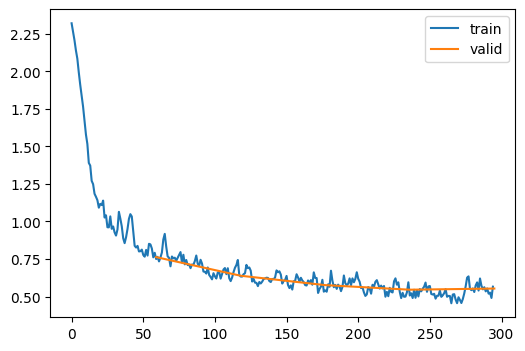

In [146]:
learn.fit(5)

In [147]:
learn.fit(train=True, valid=False)

accuracy,loss,epoch,train
0.823,0.499,0,train


In [148]:
dl = dls.train
batch = next(iter(dl))
batch

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 6, 3,  ..., 5, 6, 7]))

In [149]:
learn.predict()

In [150]:
f = partial(run_cbs, cbs, 'predict')

In [151]:
print(f(learn))

None


In [152]:
import nbdev; nbdev.nbdev_export()